In [1]:
# %pip install selenium

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [12]:
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import time
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
import time
from selenium.webdriver.support.ui import Select

### In my work, I choose cities that are closest to Vilnius and are conveniently accessible by car or other means of transport, and suitable for a few days of relaxation.

### I love to travel and discover new, quality places. Very often, I make reservations through the Booking platform.

### Recently, I've noticed that searching for vacation spots takes a lot of time, and the choices don't always satisfy me.
###  Therefore, I set myself a challenge: to create a system that helps to quickly select the best value-for-money places and reduce their number to a set limit.  

### Too many choices complicate vacation planning, and vacations should only be associated with pleasant things.

In [19]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service

# Specify the correct path to your chromedriver executable
path = '/home/paulius/bin/chromedriver'
service = Service(path)
driver = webdriver.Chrome(service=service)


In [2]:
import csv
import re
import time
from datetime import datetime, timedelta

from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

# HELPERIAI

def generate_date_ranges(start_date, end_date):
    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Generate list of dictionaries
    date_ranges = []
    current_date = start_date

    while current_date <= end_date:
        next_date = current_date + timedelta(days=1)
        date_dict = {
            "start": current_date.strftime("%Y-%m-%d"),
            "end": next_date.strftime("%Y-%m-%d")
        }
        date_ranges.append(date_dict)
        current_date = next_date
    
    return date_ranges

def scroll_down_page(driver, speed=100):
    #scroll down the page - to load all possible properties
    current_scroll_position, new_heigth = 0, 1

    while current_scroll_position <= new_heigth:
        current_scroll_position += speed

        driver.execute_script("window.scrollTo(0, {});".format(current_scroll_position))
        new_heigth = driver.execute_script("return document.body.scrollHeight")
        time.sleep(0.1)

def extract_review_count_from_element(review_count_container_inner_divs):
    review_count_string = review_count_container_inner_divs[4].text

    match = re.search(r'\d+', review_count_string)
    review_count = match.group() if match else "0"
    return review_count


def write_to_csv_file(filename, data,  write_header=False):
    with open(filename, mode='a', newline='') as file:
        # Create a CSV writer
        writer = csv.DictWriter(file, fieldnames=data[0].keys())
        
        # Write the header if needed
        if write_header:
            writer.writeheader()
        
        # Write the data
        for row in data:
            writer.writerow(row)

def get_results_for_date_range(start, end, vieta, zmoniu_sk, kambariu_sk, vaiku_sk, order_by):    
    # kelias, kaip programa nueina iki reikiamos naršyklės per mano kompiuterį.
    path = '/home/paulius/bin/chromedriver'
    #Nustatymai iš kur pasiimti reikiamus duomenis ir ką su jais daryti
    service = Service(path)
    driver = webdriver.Chrome(service=service)

    url = f"https://www.booking.com/searchresults.lt.html?ss={vieta}&checkin={start}&checkout={end}&group_adults={zmoniu_sk}&no_rooms={kambariu_sk}&group_children={vaiku_sk}&order={order_by}&nflt=distance%3D1000%3Breview_score%3D80"
    driver.get(url)

    time.sleep(3)

    scroll_down_page(driver)

    # Find all property cards
    property_boxes = driver.find_elements(By.CSS_SELECTOR, 'div[data-testid="property-card"]')

    properties_with_more_than_x_reviews = []

    for property in property_boxes:

        try:

            # Find the container with the attribute data-testid="review-score"
            review_score_container = property.find_element(By.CSS_SELECTOR, 'div[data-testid="review-score"]')


            # Find the container with the attribute data-testid="title"
            title_element = property.find_element(By.CSS_SELECTOR, 'div[data-testid="title"]')
            title = title_element.text  # Extract the text content of the title element

            title_link = property.find_element(By.CSS_SELECTOR, 'a[data-testid="title-link"]')
            href = title_link.get_attribute('href')

            price_element = property.find_element(By.CSS_SELECTOR, 'span[data-testid="price-and-discounted-price"]')
            price = price_element.text  # Extract the text content of the price element


            # Locate the element by its data-testid attribute
            score_element = property.find_element(By.CSS_SELECTOR, 'a[data-testid="secondary-review-score-link"]').get_attribute('aria-label')

            # Extract "Vieta" value from the aria-label string
            vieta_value = score_element.split(':')[1].strip()

            # Find all div elements inside the review score container
            review_count_container_inner_divs = review_score_container.find_elements(By.TAG_NAME, 'div')
            review_count = extract_review_count_from_element(review_count_container_inner_divs)

            if int(review_count) > 10:
                print(review_count, title, vieta_value)

                properties_with_more_than_x_reviews.append({
                    'title': title,
                    'review quantity': review_count,
                    'price': price,
                    'score': vieta_value,
                    'date': f"{start}-{end}",
                    'link': href
                })
            
            else:
                print('Review is less than 10, so it will be not recorded')

        except NoSuchElementException:
            print("Element not found in one of the properties, skipping...")
        continue

    driver.quit()
    time.sleep(0.2)

    return properties_with_more_than_x_reviews

# =======================================================================

#Tinklapis iš kurio imu informaciją
vieta="Vilnius"
pradzios_data="2025-07-01"
pabaigos_data="2025-08-01"
zmoniu_sk=2
kambariu_sk=1
vaiku_sk=0
order_by = "review_score_and_price"

# Failas i kuri irasysiu duomenis
csv_file = 'booking_list_in_vilnius_review_more_than_10.csv'

#pasirenkami filtrai:
#atstumas nuo miesto:
# istaigos atstumax < 1km nuo centro 'nflt=distance%3D1000'
#istaigos ivertinimo balas:
# istaiga > 8 '%3Breview_score%3D80'

# Sugeneruojam sarasa datu nuo kokios iki kokios datos norim screipint
date_ranges = generate_date_ranges(pradzios_data, pabaigos_data)

# ============================================== SCRAPINIMAS ==============================

write_header = False

for day in date_ranges:
    
    try:
        day_results = get_results_for_date_range(day["start"], day["end"], vieta, zmoniu_sk, kambariu_sk, vaiku_sk, order_by)

        if day_results:
            # Write results to CSV file
            write_to_csv_file(csv_file, day_results, write_header)

            # After the first iteration, ensure the header is not written again
            write_header = False
    except Exception as e:
        print(f"Error fetching results for {day}: {e}")
        continue


print(f"Data has been written to {csv_file}")

Review is less than 10, so it will be not recorded
Review is less than 10, so it will be not recorded
Review is less than 10, so it will be not recorded
Review is less than 10, so it will be not recorded
Review is less than 10, so it will be not recorded
821 Apartments Satva Balas 9,8
35 Apartment Vokiečių Balas 9,9
11 Angel House Vilnius, 36A Balas 10
Review is less than 10, so it will be not recorded
67 Sweet home6 Balas 9,7
63 Sweet home30 Balas 10
305 Six Apartment Simona Balas 9,8
168 Luxurious apartment Balas 9,7
Review is less than 10, so it will be not recorded
Review is less than 10, so it will be not recorded
Review is less than 10, so it will be not recorded
Review is less than 10, so it will be not recorded
Element not found in one of the properties, skipping...
Review is less than 10, so it will be not recorded
Review is less than 10, so it will be not recorded
Review is less than 10, so it will be not recorded
Review is less than 10, so it will be not recorded
Review is l

In [274]:
# # Duomenų apdorojimas:

# import csv

# with open('booking_list_in_vilnius.csv', encoding='utf-8') as file:
#     reader = csv.DictReader(file)

#     # Get the fieldnames from the original CSV file
#     fieldnames = reader.fieldnames

#     new = []

#     for filtered_row in reader:
#         if int(filtered_row['review_quantity']) > 10:
#             new.append(filtered_row)

# #Write the filered rows(with more than 10 reviews) to a new csv file:

# with open('booking_list_in_vilnius_review_more_than_10.csv', mode='w', encoding='utf-8', newline='') as new_file:
#     writer = csv.DictWriter(new_file, fieldnames=fieldnames)

#     #write the header
#     writer.writeheader()

#     #write the filterd rows
#     writer.writerows(new)

# print('Filtered data has been writen to "booking_list_in_vilnius_review_more_than_10.csv"')

    

Filtered data has been writen to "booking_list_in_vilnius_review_more_than_10.csv"


In [8]:
print(df.columns)

Index(['title', 'review_quantity', 'price', 'score', 'date', 'link',
       'start_date', 'end_date', 'start_month', 'start_month_1',
       'start_month_2', 'start_month_3', 'start_month_4', 'start_month_5',
       'start_month_6', 'start_month_7', 'start_month_8', 'start_month_9',
       'start_month_10', 'start_month_11', 'start_month_12'],
      dtype='object')


In [287]:
# # Ensure all lists have 12 values, filling with None if necessary
# def fill_missing_values(data_list, total_length=12):
#     # Fill the list with None if it is shorter than the total_length
#     return data_list + [None] * (total_length - len(data_list))

# # Fill missing values in the lists
# min_prices = fill_missing_values(min_prices)
# max_prices = fill_missing_values(max_prices)
# mean_prices = fill_missing_values(mean_prices)

# # Create pandas Series
# months = list(range(1, 13))
# min_prices_series = pd.Series(min_prices, index=months)
# max_prices_series = pd.Series(max_prices, index=months)
# mean_prices_series = pd.Series(mean_prices, index=months)

# print(min_prices_series)
# print(max_prices_series)
# print(mean_prices_series)


1     41.0
2     39.0
3     41.0
4     41.0
5     54.0
6     59.0
7     59.0
8     38.0
9     45.0
10    50.0
11    45.0
12     NaN
dtype: float64
1      430.0
2      430.0
3      430.0
4      418.0
5      430.0
6      363.0
7      307.0
8      392.0
9      350.0
10     430.0
11    1003.0
12       NaN
dtype: float64
1     108.71
2     109.11
3     108.92
4     112.43
5     140.47
6     121.18
7     127.38
8     103.60
9     105.21
10    107.42
11    123.62
12       NaN
dtype: float64


In [3]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series

#Loading data
df = pd.read_csv('booking_list_in_vilnius_review_more_than_10.csv', encoding='utf-8')

#Separating date interval
split_dates = df['date'].str.split('-', n=3, expand=True)
df['start_date'] = split_dates[0] + '-' + split_dates[1] + '-' + split_dates[2]
df['end_date'] = split_dates[3].str[:4] + '-' + split_dates[3].str[5:7] + '-' + split_dates[3].str[8:]


In [4]:

#Converting dates to a datetime format
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')

#extracting month from 'start date'
df['start_month'] = df['start_date'].dt.month


#creating binary columns for each month from 1 to 12.
for month in range(1, 13):
    df[f'start_month_{month}'] = df['start_month'] == month


#converting price column to numeric value, removing eur symbol and commas
df['price'] = df['price'].replace('[\€,]', '', regex=True)
df['price'] = df['price'].str.replace(' ', '') #removing spaces
df['price'] = pd.to_numeric(df['price'], errors='coerce') #converting to numeric



#convert review quantity to numeric
df['review_quantity'] = pd.to_numeric(df['review_quantity'], errors='coerce')

# Converting score to numeric
df['score'] = df['score'].str.extract(r'(\d+\,\d+)')[0]  # Extracting numeric part with comma
df['score'] = df['score'].str.replace(',', '.').astype(float)  # Replacing comma with dot and converting to float


In [5]:

results = {}
min_prices = []
max_prices = []
mean_prices = []

for month in range(1, 13):
    month_column = f'start_month_{month}'

    #filtered dataframe for records where the current month column is True
    month_data = df[df[month_column]]

    #cheking is the are any data for this month
    if not month_data.empty:
        min_price = month_data['price'].min()
        max_price = month_data['price'].max()
        mean_price = round(month_data['price'].mean(), 2)

        min_prices.append(min_price)
        max_prices.append(max_price)
        mean_prices.append(mean_price)

        #sort by review quantity as MOST POPULAR
        month_data_sorted_by_reviews = month_data.sort_values(by=['review_quantity', 'score'], ascending=False)

        #Find 10 cheapest results
        top_10_cheapest = month_data_sorted_by_reviews.nsmallest(10, 'price')

        #Find 10 most expensive results
        top_10_most_expensive = month_data_sorted_by_reviews.nlargest(10, 'price')

        results[f'Month_{month}'] = {
            'Min Price': min_price,
            'Max Price': max_price,
            'Mean Price': mean_price, 
            'Top 10 Cheapest': top_10_cheapest, 
            'Top 10 Most Expensive': top_10_most_expensive
        }
    else:
        results[f'Month_{month}'] = {
            'Min Price': None,
            'Max Price': None,
            'Mean Price': None,
            'Top 10 Cheapest': pd.DataFrame(), 
            'Top 10 Most Expensive': pd.DataFrame()
        }



In [6]:
results

{'Month_1': {'Min Price': 41,
  'Max Price': 430,
  'Mean Price': 108.71,
  'Top 10 Cheapest':                                                   title  review_quantity  \
  5817                                  Jimmy Jumps House              308   
  5085  HaPPy Inn ArkA the heart of Old Town, Self-Che...               68   
  5763  HaPPy Inn ArkA the heart of Old Town, Self-Che...               68   
  5796  HaPPy Inn ArkA the heart of Old Town, Self-Che...               68   
  5001                                  Jimmy Jumps House              308   
  5039                                  Jimmy Jumps House              308   
  5075                                  Jimmy Jumps House              308   
  5136                                  Jimmy Jumps House              308   
  5236                                  Jimmy Jumps House              308   
  5273                                  Jimmy Jumps House              308   
  
        price  score                   date  \

In [9]:


# Convert min_prices, max_prices, and mean_prices to pandas Series for plotting
months = list(range(1, 13))
min_prices = pd.Series(min_prices, index=months)
max_prices = pd.Series(max_prices, index=months)
mean_prices = pd.Series(mean_prices, index=months)

In [10]:

# Function to display results
def display_results(month_results):
    for month, data in month_results.items():
        print(f"\n{month}:")
        print(f"Minimum Price: {data['Min Price']}")
        print(f"Maximum Price: {data['Max Price']}")
        print(f"Mean Price: {data['Mean Price']}")

        # Display Top 10 Cheapest Listings
        print("\nTop 10 Cheapest Listings:")
        if not data['Top 10 Cheapest'].empty:
            print(data['Top 10 Cheapest'][['title', 'review_quantity', 'price', 'score', 'start_date']])
        else:
            print("No data available.")

        # Display Top 10 Most Expensive Listings
        print("\nTop 10 Most Expensive Listings:")
        if not data['Top 10 Most Expensive'].empty:
            print(data['Top 10 Most Expensive'][['title', 'review_quantity', 'price', 'score', 'start_date']])
        else:
            print("No data available.")

# Display the results
display_results(results) 





Month_1:
Minimum Price: 41
Maximum Price: 430
Mean Price: 108.71

Top 10 Cheapest Listings:
                                                  title  review_quantity  \
5817                                  Jimmy Jumps House              308   
5085  HaPPy Inn ArkA the heart of Old Town, Self-Che...               68   
5763  HaPPy Inn ArkA the heart of Old Town, Self-Che...               68   
5796  HaPPy Inn ArkA the heart of Old Town, Self-Che...               68   
5001                                  Jimmy Jumps House              308   
5039                                  Jimmy Jumps House              308   
5075                                  Jimmy Jumps House              308   
5136                                  Jimmy Jumps House              308   
5236                                  Jimmy Jumps House              308   
5273                                  Jimmy Jumps House              308   

      price  score start_date  
5817     41    9.6 2025-01-29  
5085  

<Figure size 1400x1200 with 0 Axes>

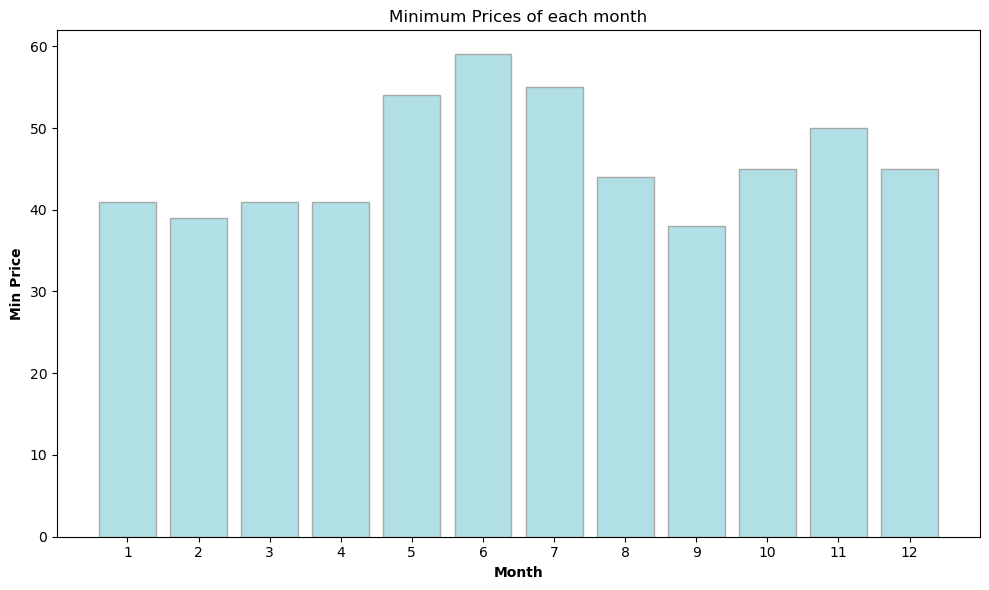

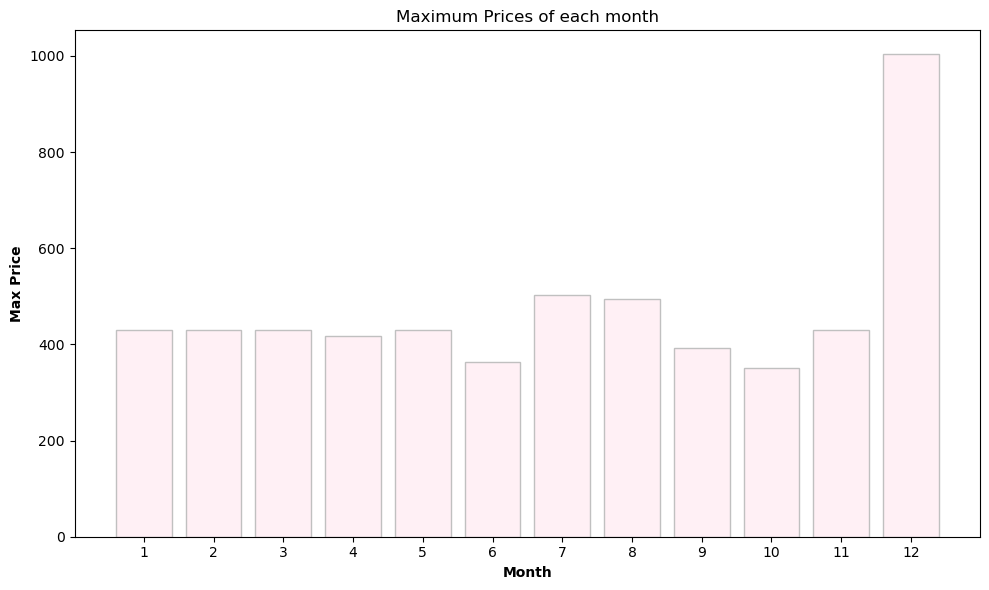

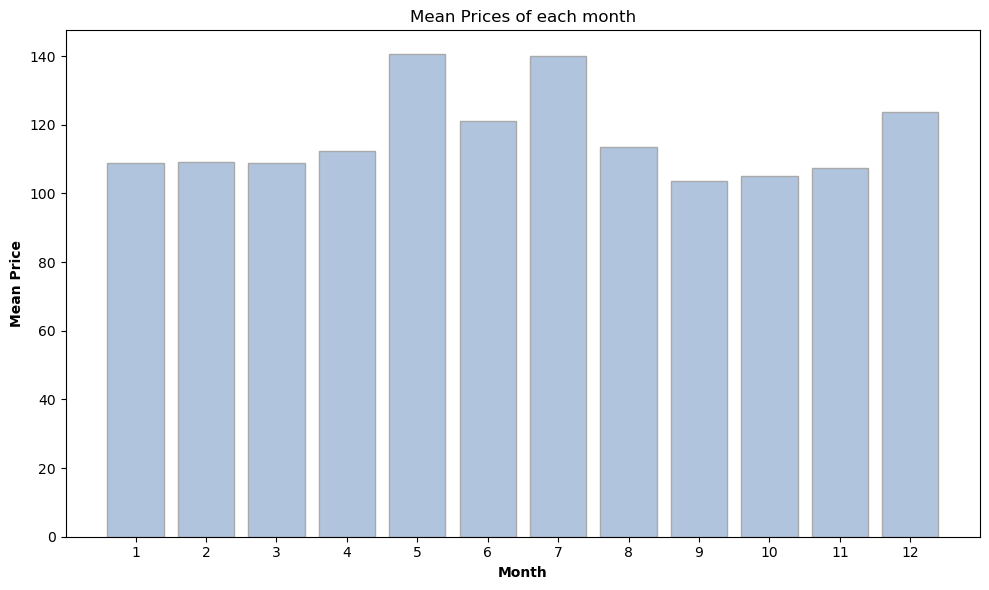

In [11]:
from tkinter import font
from turtle import color
from cairo import FontWeight
import seaborn as sns
import matplotlib.pyplot as plt


#plotting the histogram
months = list(range(1, 13))

plt.figure(figsize=(14, 12))

#histogram for minimum prices
plt.figure(figsize=(10,6))
plt.bar(months, min_prices, color='powderblue', edgecolor='darkgrey')
plt.xlabel('Month', fontweight='bold')
plt.ylabel('Min Price', fontweight='bold')
plt.xticks(months)
plt.title('Minimum Prices of each month')
plt.tight_layout()
plt.show()
# bar_width = 0.35

# Histogram for Maximum Prices
plt.figure(figsize=(10,6))
plt.bar(months, max_prices, color='lavenderblush', edgecolor='silver')
plt.xlabel('Month', fontweight='bold')
plt.ylabel('Max Price', fontweight='bold')
plt.xticks(months)
plt.title('Maximum Prices of each month')
plt.tight_layout()
plt.show()

# Histogram for Mean Prices
plt.figure(figsize=(10,6))
plt.bar(months, mean_prices, color='lightsteelblue', edgecolor='darkgrey')
plt.xlabel('Month', fontweight='bold')
plt.ylabel('Mean Price', fontweight='bold')
plt.xticks(months)
plt.title('Mean Prices of each month')
plt.tight_layout()
plt.show()

# # # Adjust layout to prevent overlap
# plt.tight_layout()

# # Show plots
# plt.show()


# #bar positions
# r1 = np.arange(len(months))
# r2 = [x + bar_width for x in r1]

# #create bars
# plt.bar(r1, min_prices, color='powderblue', width=bar_width, edgecolor='slategrey', label='Min Price')
# plt.bar(r2, max_prices, color='lavenderblush', width=bar_width, edgecolor='silver', label='Max Price')

<AxesSubplot:xlabel='score', ylabel='price'>

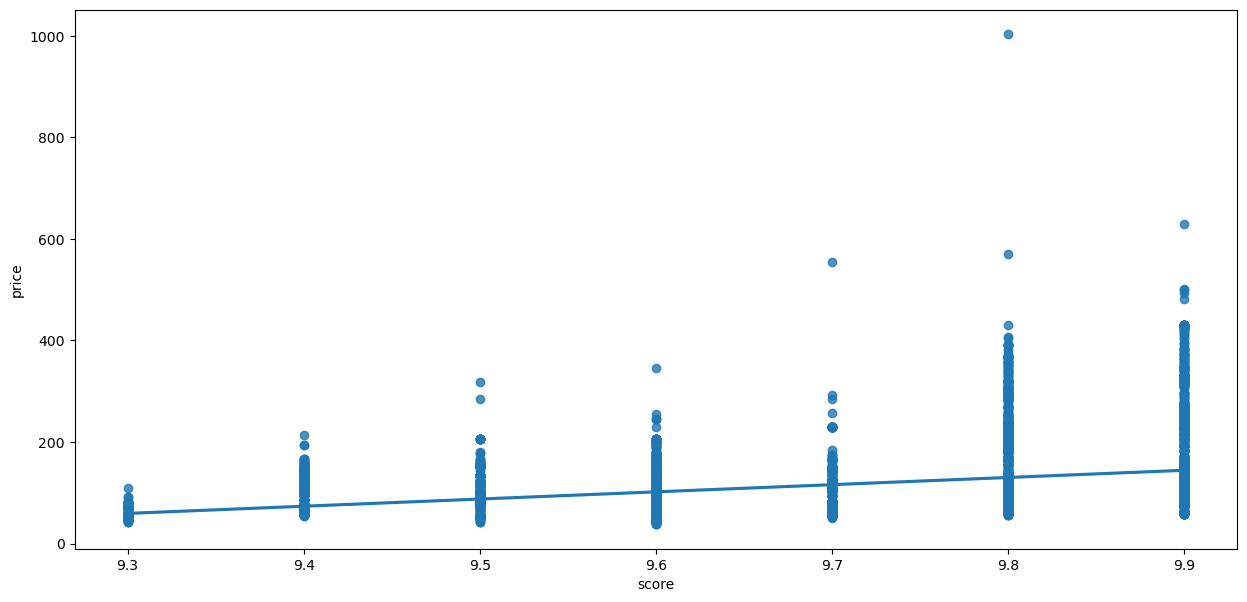

In [12]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.regplot(x='score', y='price', data= df, ax=ax)

<AxesSubplot:xlabel='review_quantity', ylabel='price'>

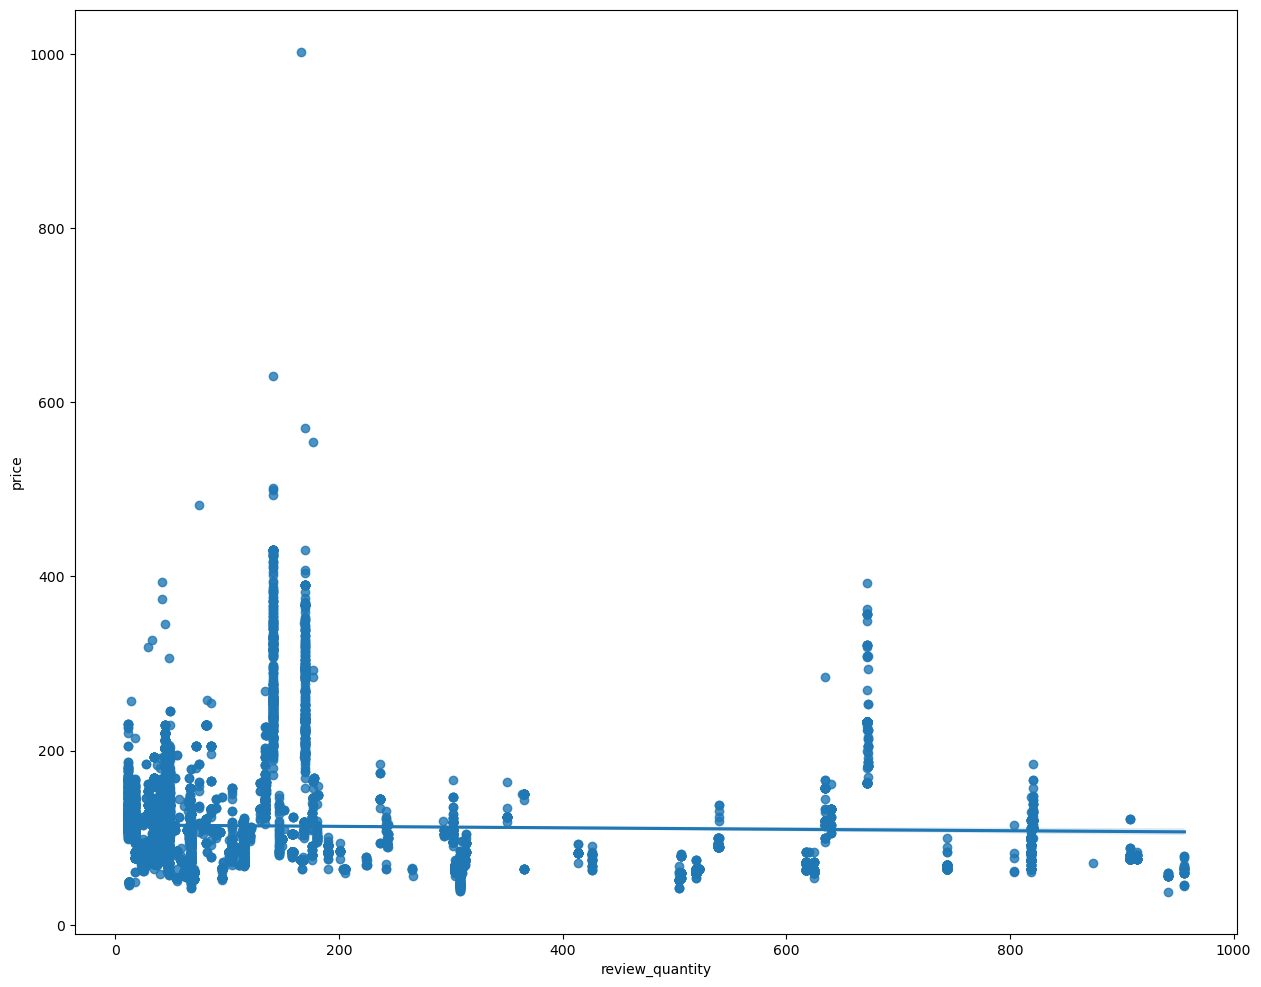

In [13]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.regplot(x='review_quantity', y='price', data= df, ax=ax)

<AxesSubplot:xlabel='score', ylabel='review_quantity'>

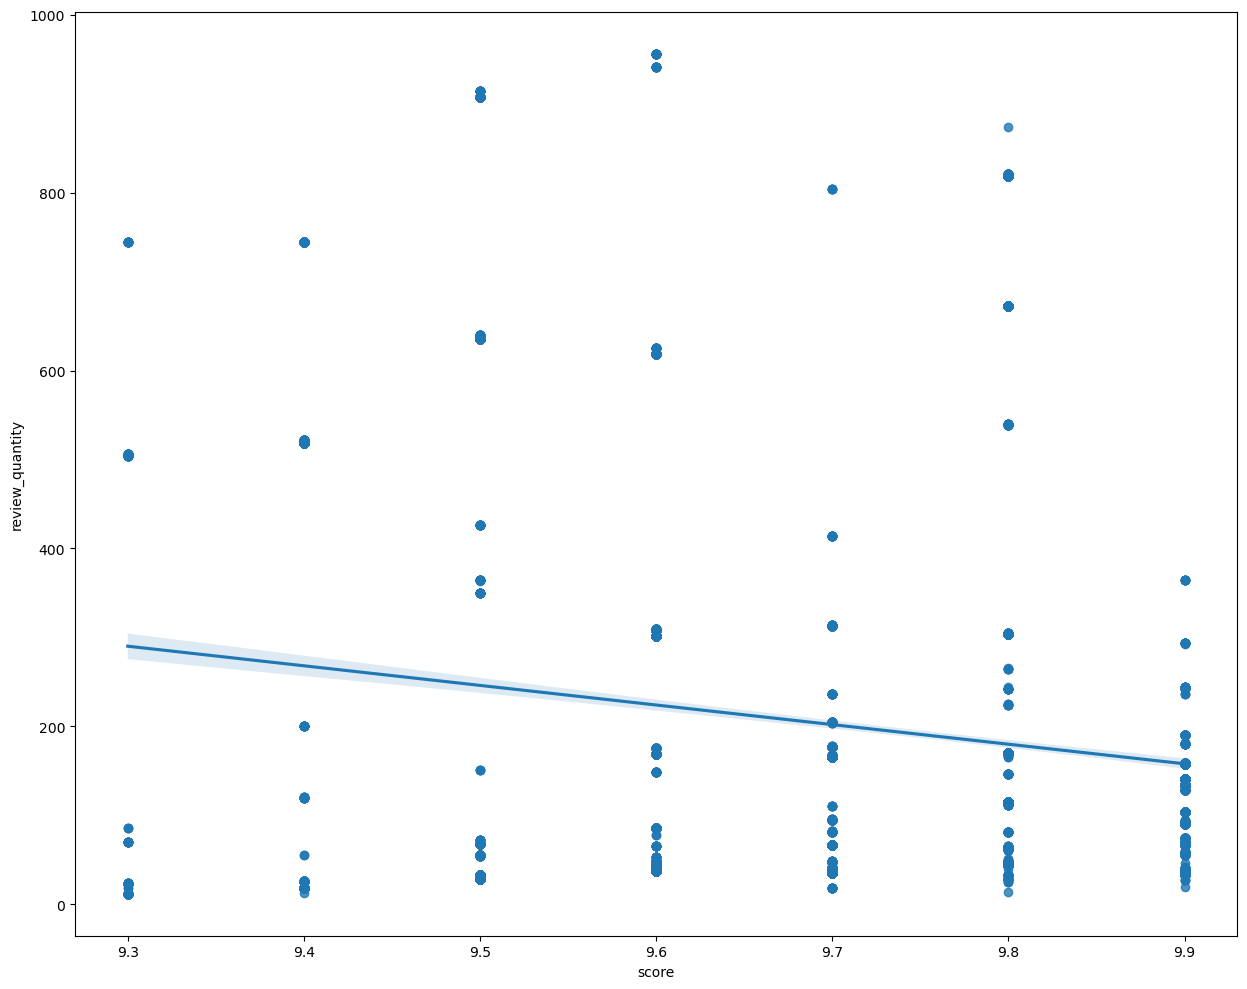

In [14]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.regplot(x='score', y='review_quantity', data= df, ax=ax)

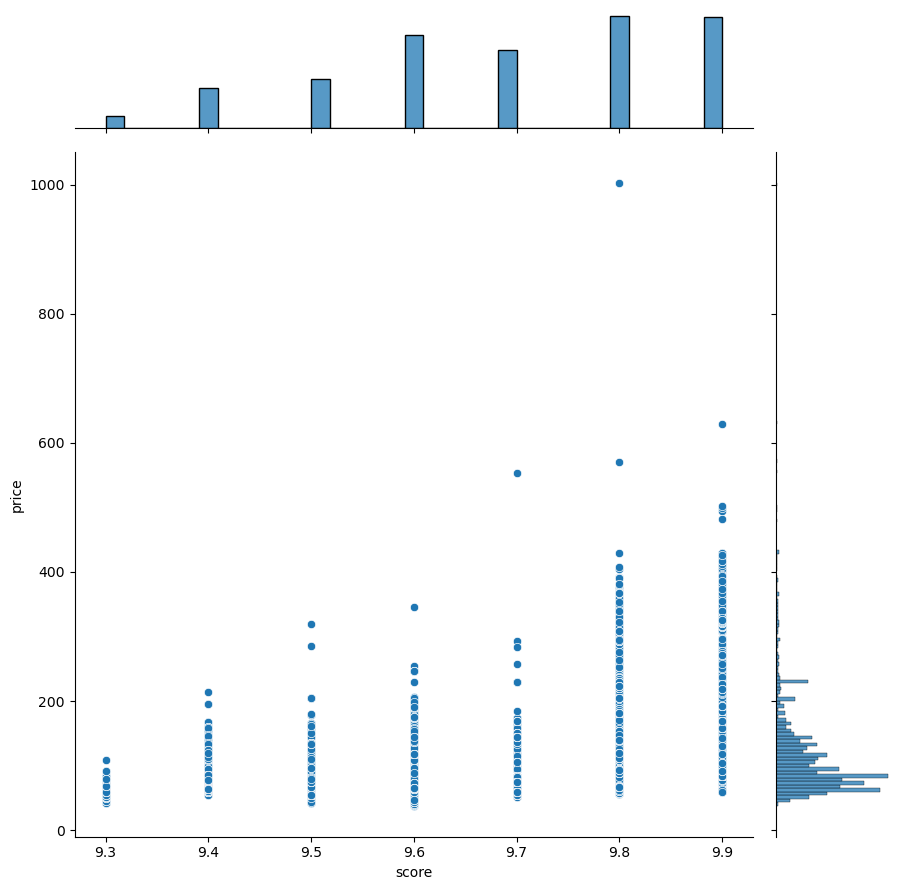

In [15]:
sns.jointplot(x="score", y="price", data=df, height=9)

In [18]:
import pandas as pd

# Function to display results with unique titles for the cheapest and most expensive referrals
def display_unique_title_results(df, month, max_price):
    # Filter data for the selected month and max price
    month_data = df[(df['start_month'] == month) & (df['price'] <= max_price)]

    
    if month_data.empty:
        print("No data available for the selected month and price range.")
        return

    # Sort by review quantity as MOST POPULAR
    month_data_sorted_by_reviews = month_data.sort_values(by=['review_quantity', 'score'], ascending=False)

    # Group by title to get unique titles
    unique_titles_cheapest = month_data_sorted_by_reviews.groupby('title').apply(lambda x: x.nsmallest(1, 'price')).reset_index(drop=True)
    unique_titles_expensive = month_data_sorted_by_reviews.groupby('title').apply(lambda x: x.nlargest(1, 'price')).reset_index(drop=True)

    # Select the top 10 cheapest unique titles
    top_10_cheapest_unique_titles = unique_titles_cheapest.nsmallest(10, 'price')

    # Select the top 10 most expensive unique titles
    top_10_most_expensive_unique_titles = unique_titles_expensive.nlargest(10, 'price')

    # Function to format DataFrame for pretty printing
    def format_for_display(df):
        # Create a formatted string for each row
        formatted_rows = []
        for index, row in df.iterrows():
            formatted_rows.append(f"{row['title']:<30} {row['review_quantity']:>5} {row['price']:>10.2f} {row['score']:>5.1f} {row['start_date'].strftime('%Y-%m-%d')} {row['link']}")
        return '\n'.join(formatted_rows)

    # Display the results with links
    print(f"\nTop 10 Cheapest Unique Titles for Month {month}:")
    if not top_10_cheapest_unique_titles.empty:
        print(format_for_display(top_10_cheapest_unique_titles))
    else:
        print("No data available.")

    print(f"\nTop 10 Most Expensive Unique Titles for Month {month}:")
    if not top_10_most_expensive_unique_titles.empty:
        print(format_for_display(top_10_most_expensive_unique_titles))
    else:
        print("No data available.")

# Load data
df = pd.read_csv('booking_list_in_vilnius_review_more_than_10.csv', encoding='utf-8')

# Separating date interval
split_dates = df['date'].str.split('-', n=3, expand=True)
df['start_date'] = split_dates[0] + '-' + split_dates[1] + '-' + split_dates[2]
df['end_date'] = split_dates[3].str[:4] + '-' + split_dates[3].str[5:7] + '-' + split_dates[3].str[8:]

# Converting dates to a datetime format
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')

# Extracting month from 'start date'
df['start_month'] = df['start_date'].dt.month

# Converting price column to numeric value, removing eur symbol and commas
df['price'] = df['price'].replace('[\€,]', '', regex=True)
df['price'] = df['price'].str.replace(' ', '')  # removing spaces
df['price'] = pd.to_numeric(df['price'], errors='coerce')  # converting to numeric

# Convert review quantity to numeric
df['review_quantity'] = pd.to_numeric(df['review_quantity'], errors='coerce')

# Converting score to numeric
df['score'] = df['score'].str.extract(r'(\d+\,\d+)')[0]  # Extracting numeric part with comma
df['score'] = df['score'].str.replace(',', '.').astype(float)  # Replacing comma with dot and converting to float

# Add 'link' column to dataframe
df['link'] = df['link'].str.strip()  # Make sure to clean up any extra spaces

# Prompt the user for inputs
try:
    month = int(input("Enter the month (1-12) you want to travel: "))
    max_price = float(input("Enter the maximum price per night: "))
    display_unique_title_results(df, month, max_price)
except ValueError:
    print("Invalid input. Please enter numeric values for month and price.")



Top 10 Cheapest Unique Titles for Month 5:
Vilnius Old Town accommodation   519      54.00   9.4 2025-05-23 https://www.booking.com/hotel/lt/old-town-guest-house.lt.html?aid=304142&label=gen173nr-1FCAQoggJCDnNlYXJjaF92aWxuaXVzSBlYBGiIAYgBAZgBGbgBGcgBDNgBAegBAfgBA4gCAagCA7gCoKegtQbAAgHSAiQ4OGQ1YTg2ZS0xMGRjLTQyZWQtYjE4My1lZTUyM2RkNzJkMjPYAgXgAgE&ucfs=1&arphpl=1&checkin=2025-05-23&checkout=2025-05-24&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=13&hapos=38&sr_order=review_score_and_price&nflt=distance%3D1000%3Breview_score%3D80&srpvid=d6ef9c1042940029&srepoch=1722291118&all_sr_blocks=286939101_108234912_2_0_0&highlighted_blocks=286939101_108234912_2_0_0&matching_block_id=286939101_108234912_2_0_0&sr_pri_blocks=286939101_108234912_2_0_0__5400&from_sustainable_property_sr=1&from=searchresults
Sweet home6                       67      59.00   9.7 2025-05-01 https://www.booking.com/hotel/lt/sweet-home6.lt.html?aid=304142&label=gen173nr-1FCAQoggJCDnNlYXJjaF92aWx

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10832 entries, 0 to 10831
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   title            10832 non-null  object        
 1   review_quantity  10832 non-null  int64         
 2   price            10832 non-null  int64         
 3   score            9768 non-null   float64       
 4   date             10832 non-null  object        
 5   link             10832 non-null  object        
 6   start_date       10832 non-null  datetime64[ns]
 7   end_date         10832 non-null  datetime64[ns]
 8   start_month      10832 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(3)
memory usage: 761.8+ KB


In [20]:
df[df['score'].isnull()]

,title,review_quantity,price,score,date,link,start_date,end_date,start_month
4,"Angel House Vilnius, 36A",11,98,NaN,2024-09-01-2024-09-02,https://www.booking.com/hotel/lt/angel-house-v...,2024-09-01,2024-09-02,9
18,"HaPPy Inn Ugnė, The studio is in the heart of ...",37,74,NaN,2024-09-01-2024-09-02,https://www.booking.com/hotel/lt/happy-inn-ugn...,2024-09-01,2024-09-02,9
59,"HaPPy Inn Ugnė, The studio is in the heart of ...",37,78,NaN,2024-09-02-2024-09-03,https://www.booking.com/hotel/lt/happy-inn-ugn...,2024-09-02,2024-09-03,9
102,"HaPPy Inn Ugnė, The studio is in the heart of ...",37,82,NaN,2024-09-03-2024-09-04,https://www.booking.com/hotel/lt/happy-inn-ugn...,2024-09-03,2024-09-04,9
150,"HaPPy Inn Ugnė, The studio is in the heart of ...",37,82,NaN,2024-09-04-2024-09-05,https://www.booking.com/hotel/lt/happy-inn-ugn...,2024-09-04,2024-09-05,9
...,...,...,...,...,...,...,...,...,...
10799,Sweet home30,63,60,NaN,2025-07-30-2025-07-31,https://www.booking.com/hotel/lt/sweet-home2.l...,2025-07-30,2025-07-31,7
10809,"Angel House Vilnius, 36A",11,159,NaN,2025-07-31-2025-08-01,https://www.booking.com/hotel/lt/angel-house-v...,2025-07-31,2025-08-01,7
10812,Sweet home30,63,60,NaN,2025-07-31-2025-08-01,https://www.booking.com/hotel/lt/sweet-home2.l...,2025-07-31,2025-08-01,7
10822,"Angel House Vilnius, 36A",11,164,NaN,2025-08-01-2025-08-02,https://www.booking.com/hotel/lt/angel-house-v...,2025-08-01,2025-08-02,8


In [21]:
# Mean Imputation
df['score'] = df['score'].fillna(df['score'].mean())


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10832 entries, 0 to 10831
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   title            10832 non-null  object        
 1   review_quantity  10832 non-null  int64         
 2   price            10832 non-null  int64         
 3   score            10832 non-null  float64       
 4   date             10832 non-null  object        
 5   link             10832 non-null  object        
 6   start_date       10832 non-null  datetime64[ns]
 7   end_date         10832 non-null  datetime64[ns]
 8   start_month      10832 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(3)
memory usage: 761.8+ KB


In [23]:

df_without_link_title_date = df.drop(columns=['link', 'title', 'date', 'start_month'])

In [24]:
df_without_link_title_date.to_csv('vilnius_data_without_link.csv', index=False)
print("The 'link' column has been removed and the new DataFrame is saved as 'booking_list_no_links.csv'.")

The 'link' column has been removed and the new DataFrame is saved as 'booking_list_no_links.csv'.


In [25]:
df_without_link_title_date

,review_quantity,price,score,start_date,end_date
0,18,80,9.700000,2024-09-01,2024-09-02
1,104,84,9.900000,2024-09-01,2024-09-02
2,112,86,9.800000,2024-09-01,2024-09-02
3,635,95,9.500000,2024-09-01,2024-09-02
4,11,98,9.695321,2024-09-01,2024-09-02
...,...,...,...,...,...
10827,168,74,9.700000,2025-08-01,2025-08-02
10828,141,355,9.900000,2025-08-01,2025-08-02
10829,49,144,9.600000,2025-08-01,2025-08-02
10830,170,323,9.800000,2025-08-01,2025-08-02


In [27]:
df_without_link_title_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10832 entries, 0 to 10831
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   review_quantity  10832 non-null  int64         
 1   price            10832 non-null  int64         
 2   score            10832 non-null  float64       
 3   start_date       10832 non-null  datetime64[ns]
 4   end_date         10832 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 423.2 KB


### Linear regression

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
#Spliting data into features and target

from sklearn.model_selection import train_test_split

X = df_without_link_title_date.drop(columns=['price'])
y = df_without_link_title_date['price']


#Spliting start date column to 3 different columns
df_without_link_title_date['year'] = df_without_link_title_date['start_date'].dt.year
df_without_link_title_date['month'] = df_without_link_title_date['start_date'].dt.month
df_without_link_title_date['day'] = df_without_link_title_date['start_date'].dt.day


In [30]:
import pandas as pd
import numpy as np

# Assuming X is your DataFrame
datetime_columns = X.select_dtypes(include=[np.datetime64]).columns

# Convert datetime columns to numerical features
for col in datetime_columns:
    X[col + '_year'] = X[col].dt.year
    X[col + '_month'] = X[col].dt.month
    X[col + '_day'] = X[col].dt.day
    # Drop the original datetime column
    X = X.drop(columns=[col])

# Now X should no longer contain datetime columns


In [31]:
df_without_link_title_date

,review_quantity,price,score,start_date,end_date,year,month,day
0,18,80,9.700000,2024-09-01,2024-09-02,2024,9,1
1,104,84,9.900000,2024-09-01,2024-09-02,2024,9,1
2,112,86,9.800000,2024-09-01,2024-09-02,2024,9,1
3,635,95,9.500000,2024-09-01,2024-09-02,2024,9,1
4,11,98,9.695321,2024-09-01,2024-09-02,2024,9,1
...,...,...,...,...,...,...,...,...
10827,168,74,9.700000,2025-08-01,2025-08-02,2025,8,1
10828,141,355,9.900000,2025-08-01,2025-08-02,2025,8,1
10829,49,144,9.600000,2025-08-01,2025-08-02,2025,8,1
10830,170,323,9.800000,2025-08-01,2025-08-02,2025,8,1


In [32]:
#Droping datetime columns from X for scaling(mastelio keitimui)

X_for_scaling = df_without_link_title_date.drop(columns=['start_date', 'end_date'])
y = df_without_link_title_date['price']



In [33]:
X_for_scaling

,review_quantity,price,score,year,month,day
0,18,80,9.700000,2024,9,1
1,104,84,9.900000,2024,9,1
2,112,86,9.800000,2024,9,1
3,635,95,9.500000,2024,9,1
4,11,98,9.695321,2024,9,1
...,...,...,...,...,...,...
10827,168,74,9.700000,2025,8,1
10828,141,355,9.900000,2025,8,1
10829,49,144,9.600000,2025,8,1
10830,170,323,9.800000,2025,8,1


In [34]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_for_scaling, y, test_size=0.33, random_state=42)


#Standartazing data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)
X_test_scaled = scaler.transform(X_test)


#model building
model = LinearRegression()
model.fit(X_train_scaled, y_train)

#predictions
y_pred = model.predict(X_test_scaled)

# numpPy array converting to pandas series
predictions = pd.Series(data=y_pred, name='Predictions')

In [36]:
#model evaluating

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 2.90812745233252e-27
R-squared: 1.0


POZYMIAI: 

review quantity  
score  
price  








# susisplitinti. daryti kryzmini ir grid searcha.
# LAso, ridge, random forest. gintarevcs@gmail.com 860547452.

pries gridsearcha pasidaryti polinominius pozymius.

PAsiprognazuoti su regresijomis: tiesine, laso,(dar vien kokia nors, pvz misku, kaimynai ar pan.) neuronini tinkla(multilayer perceptron MLP(vertinsim koks mse tikslumas), lstm)
GAle palyginti reikes kas geriausiai prognozuoja, palyginti viena su kitu.

susirasti kuris klasifikatorius tiksliausiai speja.

tada su UI duoti susivesti duomenis, kad jam nuspetu kada jam geriausia kainos pasiulyma, jei tuo laikotarpiu nuomotusi. linearregsesion - ten yra ui vz. 






??? dar galiu pasirasyti valstybiniu svenciu datas, savaitgalius, mokiniu atostogu datas ir juos issitrinti. Tuomet palyginti kaip keiciasi kainos paprastomis dienomis.

Duomenu spejimas:

-prognozuoti kainas sekantiems metams.


Klasifikavimas: zema kaina, vidutine kaina, auksta kaina.